# Model prototyping

This notebook trains and publishes prototype models.

## Change working directory to project root

In [1]:
import os
ROOT_DIRECTORIES = {'mlops', 'tests'}
if set(os.listdir('.')).intersection(ROOT_DIRECTORIES) != ROOT_DIRECTORIES:
    os.chdir('../../../../..')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets.widgets import IntSlider, interact
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, \
    Dropout
from mlops.dataset.versioned_dataset import VersionedDataset
from mlops.examples.image.classification.train_model import train_model, \
    publish_model
from mlops.examples.image.classification.pokemon_classification_data_processor \
    import PokemonClassificationDataProcessor

In [3]:
DATASET_PUBLICATION_PATH_LOCAL = 'datasets/pokemon'
DATASET_VERSION = 'v1'
MODEL_PUBLICATION_PATH_LOCAL = 'models/pokemon'
MODEL_CHECKPOINT_FILENAME = 'models/pokemon/checkpoints/model_best.h5'

## Retrieve versioned dataset

In [4]:
dataset = VersionedDataset(os.path.join(DATASET_PUBLICATION_PATH_LOCAL,
                                        DATASET_VERSION))

## Define prototype model

In [5]:
model = Sequential()
# Shape: (None, 120, 120, 3).
model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=dataset.X_train.shape[1:]))
# Shape: (None, 118, 118, 16).
model.add(MaxPooling2D((2, 2)))
# Shape: (None, 59, 59, 16).
model.add(Conv2D(32, (3, 3), activation='relu'))
# Shape: (None, 57, 57, 32).
model.add(MaxPooling2D((2, 2)))
# Shape: (None, 28, 28, 32).
model.add(Conv2D(64, (3, 3), activation='relu'))
# Shape: (None, 26, 26, 64).
model.add(MaxPooling2D((2, 2)))
# Shape: (None, 13, 13, 64).
model.add(Conv2D(128, (3, 3), activation='relu'))
# Shape: (None, 11, 11, 128).
model.add(MaxPooling2D((2, 2)))
# Shape: (None, 5, 5, 128).
model.add(Conv2D(256, (3, 3), activation='relu'))
# Shape: (None, 3, 3, 256).
model.add(Flatten())
# Shape: (None, 2304).
model.add(Dense(128, activation='relu'))
# Shape: (None, 128).
model.add(Dropout(0.4))
# Shape: (None, 128).
model.add(Dense(dataset.y_train.shape[1], activation='sigmoid'))
# Shape: (None, 18).
model.compile(optimizer='adam', loss='binary_crossentropy')

2021-12-14 15:48:57.000125: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Train and publish the versioned model

In [6]:
training_config = train_model(
    model,
    dataset,
    model_checkpoint_filename=MODEL_CHECKPOINT_FILENAME,
    epochs=5,
    batch_size=4)
publish_model(
    model,
    dataset,
    training_config,
    MODEL_PUBLICATION_PATH_LOCAL,
    tags=['prototype'])

Epoch 1/5
2/2 [==============================] - 1s 171ms/step - loss: 0.6785 - val_loss: 0.6109
Epoch 2/5
2/2 [==============================] - 0s 65ms/step - loss: 0.5594 - val_loss: 0.4247
Epoch 3/5
2/2 [==============================] - 0s 67ms/step - loss: 0.5053 - val_loss: 0.3940
Epoch 4/5
2/2 [==============================] - 0s 71ms/step - loss: 0.3449 - val_loss: 0.3151
Epoch 5/5
2/2 [==============================] - 0s 67ms/step - loss: 0.4068 - val_loss: 0.2870


## Examine results

In [7]:
pred = PokemonClassificationDataProcessor.get_valid_prediction(
    model.predict(dataset.X_val))
pred = dataset.data_processor.unpreprocess_labels(pred)
labels = dataset.data_processor.unpreprocess_labels(dataset.y_val)

In [8]:
def show_img_and_pred(idx: int) -> None:
    """Plots the image at the given index and prints prediction info."""
    print(f'Validation image: {idx}')
    print(f'Label: {labels[idx]}')
    print(f'Prediction: {pred[idx]}')
    fig = plt.imshow(dataset.X_val[idx])
    plt.show()

_ = interact(show_img_and_pred, idx=IntSlider(value=0,
                                              min=0,
                                              max=len(dataset.X_val) - 1,
                                              step=1))

interactive(children=(IntSlider(value=0, description='idx', max=1), Output()), _dom_classes=('widget-interact'…

In [9]:
pre = dataset.data_processor.preprocess_features(dataset.X_train)

hello new preprocessing


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


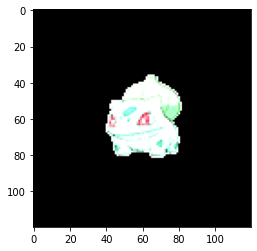

In [11]:
plt.imshow(pre[0])